# Data load

Завантажимо дані, які використовувались в lab1

In [59]:
!pip install ucimlrepo

In [60]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
drug_consumption_quantified = fetch_ucirepo(id=373)

# data (as pandas dataframes)
X = drug_consumption_quantified.data.features
y = drug_consumption_quantified.data.targets

In [61]:
dataset_with_targets = drug_consumption_quantified.data.original
dataset_with_targets.shape

(1885, 32)

In [62]:
cols_to_drop = [col for col in y.columns if col != 'cannabis']

# Видаляємо їх із dataset_with_targets
new_dataset_with_targets = dataset_with_targets.drop(columns=cols_to_drop)
new_dataset_with_targets = new_dataset_with_targets.drop(columns='id')
new_dataset_with_targets['cannabis'] = new_dataset_with_targets['cannabis'].replace(
    {f'CL{i}': i for i in range(7)}
).astype(int)
# Перевіримо результат
new_dataset_with_targets.head()

/tmp/ipython-input-1077137910.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_dataset_with_targets['cannabis'] = new_dataset_with_targets['cannabis'].replace(


,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss,cannabis
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,4
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,3
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,2
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,3


In [63]:
# Створюємо мапу старих класів на нові
mapping1 = {
    0: 0,                # Never Used
    1: 1, 2: 1,          # Used over a Decade Ago + Used in Last Decade
    3: 2, 4: 2, 5: 2,    # Used in Last Year/Month/Week
    6: 3                 # Used in Last Day
}

mapping2 = {
    0: 0, 1: 0,
    2: 1, 3: 1,
    4: 2, 5: 2, 6: 2
}

mapping3 = {
    0: 0, 1: 0, 2: 0,
    3: 1, 4: 1, 5: 1, 6: 1
}


new_dataset_with_targets['cannabis_new1'] = new_dataset_with_targets['cannabis'].map(mapping1)
new_dataset_with_targets['cannabis_new2'] = new_dataset_with_targets['cannabis'].map(mapping2)
new_dataset_with_targets['cannabis_new3'] = new_dataset_with_targets['cannabis'].map(mapping3)

In [64]:
new_dataset_with_targets.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss,cannabis,cannabis_new1,cannabis_new2,cannabis_new3
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0,0,0,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,4,2,2,1
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,3,2,1,1
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,2,1,1,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,3,2,1,1


# 1. Зниження розмірності і візуалізація даних

In [65]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [66]:
results = []  # список для збору результатів

def fit_eval(pipeline, X_train, y_train, X_test, y_test, label="model"):
    t0 = time.perf_counter()
    pipeline.fit(X_train, y_train)
    t1 = time.perf_counter()
    y_pred = pipeline.predict(X_test)
    t2 = time.perf_counter()

    # Основні метрики
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # Якщо є PCA — виводимо додаткові характеристики
    n_components = None
    explained_var = None
    if "pca" in dict(pipeline.named_steps):
        pca = pipeline.named_steps["pca"]
        n_components = pca.n_components_
        explained_var = pca.explained_variance_ratio_.sum()
    else:
        n_components = X_train.shape[1]
        explained_var = 1.0

    # Додаємо результат у таблицю
    results.append({
        "Model": label,
        "n_components": n_components,
        "Explained_var": round(explained_var, 3),
        "Accuracy": round(acc, 4),
        "Precision_macro": round(report["macro avg"]["precision"], 4),
        "Recall_macro": round(report["macro avg"]["recall"], 4),
        "F1_macro": round(report["macro avg"]["f1-score"], 4),
        "Fit_time (s)": round(t1 - t0, 4),
        "Predict_time (s)": round(t2 - t1, 6)
    })

    # Вивід confusion matrix у консоль
    print(f"\n🔹 {label}")
    print("Confusion matrix:\n", cm)

Використаємо SVM з найкращими параметрами (отримані за допомогою GridSearch), визначеними в Lab1 для target='cannabis'. Параметри
* target	cannabis
* best_score	0.4456
* best_scaler	RobustScaler
* best_params 'C': 100, 'gamma': 0.01, 'kernel': 'rbf'

In [67]:
targets = ['cannabis', 'cannabis_new1', 'cannabis_new2', 'cannabis_new3']

# --- Дані ---
X = new_dataset_with_targets.drop(targets, axis=1)
y = new_dataset_with_targets['cannabis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

# --- Моделі ---
pipe_svc = Pipeline([
    ("scaler", RobustScaler()),
    ("svc", SVC(C=100, gamma=0.01, kernel='rbf'))
])
# зі зменшенням розмірності
pipe_pca_svc = Pipeline([
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=0.95, svd_solver="full", random_state=42)),  # залишає 95% дисперсії
    ("svc", SVC(C=100, gamma=0.01, kernel='rbf'))
])

# --- Крос-валідація ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_svc = cross_val_score(pipe_svc, X_train, y_train, cv=cv, scoring="accuracy")
cv_pca_svc = cross_val_score(pipe_pca_svc, X_train, y_train, cv=cv, scoring="accuracy")

In [68]:
# --- Використання ---
fit_eval(pipe_svc, X_train, y_train, X_test, y_test, label="cannabis SVM (no PCA)")
fit_eval(pipe_pca_svc, X_train, y_train, X_test, y_test, label="cannabis PCA(0.95)+SVM")

# --- Формуємо таблицю результатів ---
results_df = pd.DataFrame(results)
results_df


🔹 cannabis SVM (no PCA)
Confusion matrix:
 [[68  3  3  4  0  0  5]
 [23  9  5  0  0  0  4]
 [27  5  7  0  0  0 14]
 [ 8  1  6  0  0  0 27]
 [ 5  2  4  2  0  0 15]
 [ 4  1  3  0  0  0 29]
 [ 3  2  2  1  0  1 84]]

🔹 cannabis PCA(0.95)+SVM
Confusion matrix:
 [[67  3  1  2  0  0 10]
 [24  6  4  2  0  0  5]
 [29  6  4  1  0  0 13]
 [ 8  1  5  1  0  0 27]
 [ 5  1  3  0  0  1 18]
 [ 3  1  2  1  0  0 30]
 [ 3  2  8  1  0  1 78]]


,Model,n_components,Explained_var,Accuracy,Precision_macro,Recall_macro,F1_macro,Fit_time (s),Predict_time (s)
0,cannabis SVM (no PCA),12,1.000,0.4456,0.2270,0.2963,0.2407,0.2353,0.039687
1,cannabis PCA(0.95)+SVM,10,0.973,0.4138,0.2123,0.2702,0.2157,0.4537,0.035187


Спробуємо також для target 3 з параметрами
RobustScaler	{'model__C': 100, 'model__gamma': 0.01, 'model...

In [69]:
# --- Дані ---
X = new_dataset_with_targets.drop(targets, axis=1)
y = new_dataset_with_targets['cannabis_new3']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

# --- Крос-валідація ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_svc = cross_val_score(pipe_svc, X_train, y_train, cv=cv, scoring="accuracy")
cv_pca_svc = cross_val_score(pipe_pca_svc, X_train, y_train, cv=cv, scoring="accuracy")

In [70]:
fit_eval(pipe_svc, X_train, y_train, X_test, y_test, label="cannabis_new3 SVM (no PCA)")
fit_eval(pipe_pca_svc, X_train, y_train, X_test, y_test, label="cannabis_new3 PCA(0.95)+SVM")


# --- Формуємо таблицю результатів ---
results_df = pd.DataFrame(results)
results_df


🔹 cannabis_new3 SVM (no PCA)
Confusion matrix:
 [[137  40]
 [ 33 167]]

🔹 cannabis_new3 PCA(0.95)+SVM
Confusion matrix:
 [[138  39]
 [ 39 161]]


,Model,n_components,Explained_var,Accuracy,Precision_macro,Recall_macro,F1_macro,Fit_time (s),Predict_time (s)
0,cannabis SVM (no PCA),12,1.000,0.4456,0.2270,0.2963,0.2407,0.2353,0.039687
1,cannabis PCA(0.95)+SVM,10,0.973,0.4138,0.2123,0.2702,0.2157,0.4537,0.035187
2,cannabis_new3 SVM (no PCA),12,1.000,0.8064,0.8063,0.8045,0.8051,0.2545,0.028880
3,cannabis_new3 PCA(0.95)+SVM,10,0.971,0.7931,0.7923,0.7923,0.7923,0.2121,0.030866


## Висновок 1.1

Якість класифікації (Accuracy, F1-score): Для обох цільових змінних після зменшення розмірності за допомогою PCA точність зменшилась. Це очікувано, оскільки PCA прибирає частину інформації, яка може бути корисною для класифікації. Падіння невелике (≈ 1–3 %), тому PCA не зруйнувало модель, але не допомогло.

Швидкість навчання та прогнозу: Для cannabis час навчання трохи збільшився, хоча кількість ознак зменшилась (з 12 до 10). Це може бути через додаткові обчислення PCA перед SVM. Для cannabis_new3 ситуація схожа: навчання трохи повільніше, прогноз — практично такий самий.Отже, PCA не пришвидшило навчання, тому що обсяг даних невеликий і витрати на сам PCA перекривають виграш.

Отже, для цього набору даних SVM краще працює на повному просторі ознак. PCA може бути корисним лише при дуже великій кількості ознак або за наявності сильно скорельованих фіч.

## Зниження розмірності до 2D

Порівняємо PCA з TSNE

In [71]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
# Приклад для одного з таргетів
target = 'cannabis'
X = new_dataset_with_targets.drop(targets, axis=1)
y = new_dataset_with_targets[target]

# Масштабуємо, бо чутливий до різних масштабів
X_scaled = StandardScaler().fit_transform(X)

* PCA

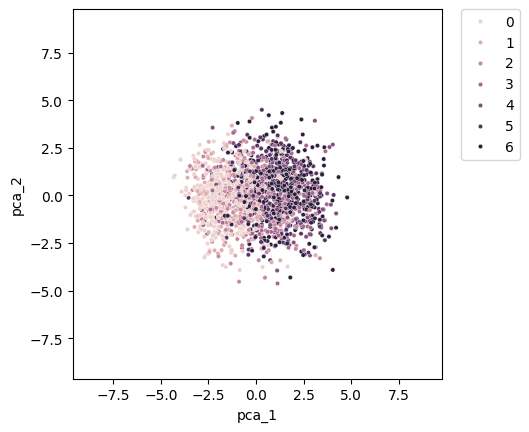

In [73]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

pca_result_df = pd.DataFrame({'pca_1': pca_result[:,0], 'pca_2': pca_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax,s=10)
lim = (pca_result.min()-5, pca_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

* TSNE

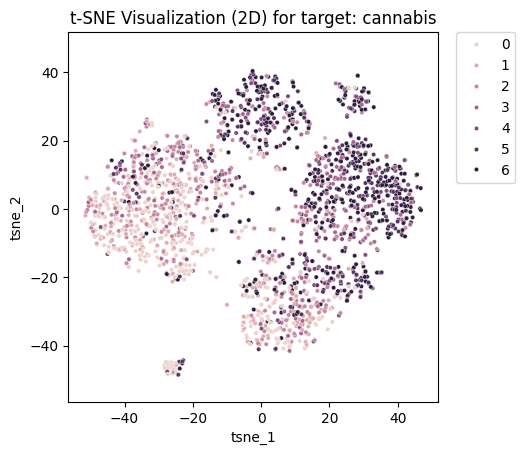

In [74]:
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

tsne_result_df = pd.DataFrame({
    'tsne_1': tsne_result[:,0],
    'tsne_2': tsne_result[:,1],
    'target': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='target', data=tsne_result_df, ax=ax,s=10)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title(f't-SNE Visualization (2D) for target: {target}')
plt.show()

якщо використати RobustScaler

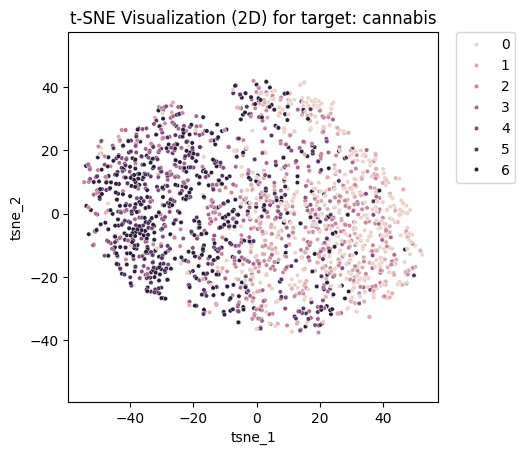

In [75]:
X_scaled = RobustScaler().fit_transform(X)

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

tsne_result_df = pd.DataFrame({
    'tsne_1': tsne_result[:,0],
    'tsne_2': tsne_result[:,1],
    'target': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='target', data=tsne_result_df, ax=ax,s=10)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title(f't-SNE Visualization (2D) for target: {target}')
plt.show()

## Висновок 1.2

t-SNE чудово показує кластеризацію або перетини між класами — візуально можна побачити, наскільки чітко поділяються групи (наприклад, класи 0–6 у cannabis). Точки значною мірою перекриваються, тому модель (як-от SVM або kNN) має нижчу точність. Як видно, можна знайти підтвердження тому, що розподіл класів на два класи, як в таргеті cannabis_new3, дасть високу точність моделей, що було показано в lab1. Також, можна спостерігати, що на відміну від PCA, який показує однакові результати для StandardScaler i RobustScaler, TSNE краще відпрацьовує для StandardScaler. RobustScaler обмежує вплив викидів, але також зменшує варіативність корисної інформації у даних, яку t-SNE може використовувати для розділення класів. StandardScaler нормалізує всі ознаки до середнього 0 та ст. відхилення 1, зберігаючи відносну дисперсію, що краще підходить t-SNE для побудови кластерів і збереження локальної структури.

# 2. Кластерний аналіз

In [76]:
from skimage import data

# вибір зображення
image = data.chelsea()   # RGB зображення кота

Image shape: (300, 451, 3)
dtype: uint8


array([[[143, 120, 104],
        [143, 120, 104],
        [141, 118, 102],
        ...,
        [ 45,  27,  13],
        [ 45,  27,  13],
        [ 45,  27,  13]],

       [[146, 123, 107],
        [145, 122, 106],
        [143, 120, 104],
        ...,
        [ 46,  29,  13],
        [ 45,  29,  13],
        [ 47,  30,  14]],

       [[148, 126, 112],
        [147, 125, 111],
        [146, 122, 109],
        ...,
        [ 48,  28,  17],
        [ 49,  29,  18],
        [ 50,  30,  19]],

       ...,

       [[ 92,  58,  30],
        [105,  71,  43],
        [132,  98,  71],
        ...,
        [172, 145, 138],
        [172, 145, 138],
        [172, 145, 138]],

       [[128,  92,  60],
        [139, 103,  71],
        [134,  95,  64],
        ...,
        [166, 142, 132],
        [166, 142, 132],
        [167, 143, 133]],

       [[139, 103,  71],
        [127,  88,  57],
        [125,  86,  53],
        ...,
        [161, 137, 127],
        [161, 137, 127],
        [162, 138, 128]]], dtype=uint8)
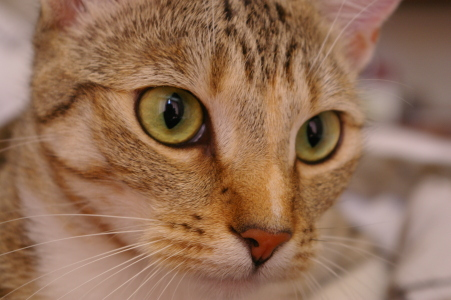

In [77]:
print("Image shape:", image.shape)
print("dtype:", image.dtype)
image

Зображення можна уявити як набір точок у 3D-просторі. Кожен піксель = вектор (R, G, B). Алгоритм k-means шукає k «репрезентативних» кольорів (центроїдів), а потім замінює кожен піксель найближчим центроїдом.

Унікальних кольорів у вихідному зображенні: 32584
Унікальних кольорів у перетвореному зображенні: 64
Унікальних кольорів у перетвореному зображенні: 32
Унікальних кольорів у перетвореному зображенні: 16
Унікальних кольорів у перетвореному зображенні: 8
Унікальних кольорів у перетвореному зображенні: 4


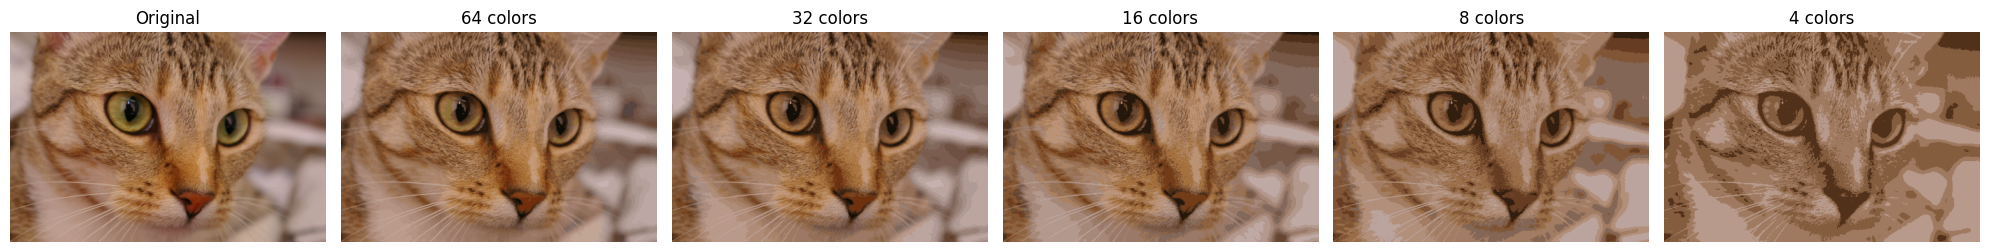

In [78]:
from sklearn.cluster import KMeans


# --- Підрахунок унікальних кольорів ---
unique_colors_original = np.unique(image.reshape(-1, 3), axis=0)
print("Унікальних кольорів у вихідному зображенні:", unique_colors_original.shape[0])

# --- Нормалізація
data = image / 255.0
# --- Перетворення зображення у 2D масив (пікселі × RGB) ---
pixels = data.reshape(-1, 3)

# --- Список кількості кольорів для квантування ---
colors_list = [64, 32, 16, 8, 4]

# --- Фігура для порівняння ---
fig, axes = plt.subplots(1, len(colors_list)+1, figsize=(20, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")

for i, n_colors in enumerate(colors_list):
    # k-means для кластеризації пікселів
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    # Формат uint8 дозволяє закодувати 16,7 мільйона кольорів
    # (кількість можливих комбінацій у зображені з трьома каналами)
    # 256×256×256 (але кожне конкретне зображення зазвичай містить значно менше унікальних кольорів)
    new_colors = kmeans.cluster_centers_  #.astype(np.uint8)

    # Замінюємо пікселі на центри кластерів
    quantized_img = new_colors[labels].reshape(image.shape)

    unique_colors_quantized = np.unique(quantized_img.reshape(-1, 3), axis=0)
    print("Унікальних кольорів у перетвореному зображенні:", unique_colors_quantized.shape[0])

    axes[i+1].imshow(quantized_img)
    axes[i+1].set_title(f"{n_colors} colors")
    axes[i+1].axis("off")

plt.tight_layout()
plt.show()

## Висновок 2

Для даного зображення голови кота квантування зображення за допомогою алгоритму K-means з глибиною 64, 32, 16, 8 та 4 пройшло успішно. На зображенні добре видно кота та його риси, навіть при зменшенні кількості кольорів, завдяки тому, що переважають відтінки коричневого. Алгоритм ефективно зберігає півтони основного кольору, а деталі рідкісних кольорів майже не впливають на сприйняття зображення.

# 3. Обробка та класифікація текстових даних

Посилання на опис датасету https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch

In [79]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhileswarkomati/suicide-watch")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'suicide-watch' dataset.
Path to dataset files: /kaggle/input/suicide-watch


In [80]:
import os

files = os.listdir(path)
print("Files in dataset folder:", files)

# Припустимо, там є файл "Suicide_Detection.csv"
csv_path = os.path.join(path, "Suicide_Detection.csv")

# Завантажуємо CSV
df = pd.read_csv(csv_path)
df = df.drop(columns=["Unnamed: 0"])

Files in dataset folder: ['Suicide_Detection.csv']


In [81]:
df.head()

,text,class
0,"Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.",suicide
1,Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it,non-suicide
2,"Finally 2020 is almost over... So I can never hear ""2020 has been a bad year"" ever again. I swear to fucking God it's so annoying",non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’ve been struggling for years and I’m afraid. Through these past years thoughts of suicide, fear, anxiety I’m so close to my limit . I’ve been quiet for so long and I’m too scared to come out to my family about these feelings. About 3 years ago losing my aunt triggered it all. Everyday feeling hopeless , lost, guilty, and remorseful over her and all the things I’ve done in my life,but thoughts like these with the little I’ve experienced in life? Only time I’ve revealed these feelings to my family is when I broke down where they saw my cuts. Watching them get so worried over something I portrayed as an average day made me feel absolutely dreadful. They later found out I was an attempt survivor from attempt OD(overdose from pills) and attempt hanging. All that happened was a blackout from the pills and I never went through with the noose because I’m still so afraid. During my first therapy I was diagnosed with severe depression, social anxiety, and a eating disorder.\nI was later transferred to a fucken group therapy for some reason which made me feel more anxious. Eventually before my last session with a 1 on 1 therapy she showed me my results from a daily check up on my feelings(which was a 2 - step survey for me and my mom/dad )\nCome to find out as I’ve been putting feeling horrible and afraid/anxious everyday , my mom has been doing I’ve been doing absolutely amazing with me described as “happiest she’s ever seen me, therapy has helped him” \nI eventually was put on Sertaline (anti anxiety or anti depression I’m sorry I forgot) but I never finished my first prescription nor ever found the right type of anti depressant because my mom thought I only wanted the drugs so she took me off my recommended pill schedule after ~3 week and stopped me from taking them. All this time I’ve been feeling worse afraid of the damage/ worry I’ve caused them even more. \nNow here with everything going on, I’m as afraid as I’ve ever been . I’ve relapsed on cutting and have developed severe insomnia . Day after day feeling more hopeless, worthless questioning why am I still here? What’s my motivation to move out of bed and keep going? I ask these to myself nearly every night almost having a break down everytime. \nPlease Please Please someone.. anyone help me.\nI’m so scared I might do something drastic, I’ve been shaped by fear and anxiety. Idk what to do anymore",suicide


In [82]:
df.columns, df.shape

(Index(['text', 'class'], dtype='object'), (232074, 2))

In [83]:
df.isnull().sum()

,0
text,0
class,0


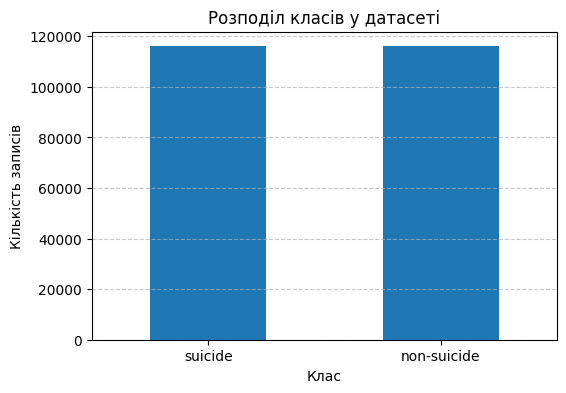

In [84]:
label_counts = df['class'].value_counts()

# Побудова графіка
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar')

plt.title("Розподіл класів у датасеті")
plt.xlabel("Клас")
plt.ylabel("Кількість записів")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Класи рівномірно розподілені.

In [85]:
df['text'].head()

,text
0,"Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen."
1,Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it
2,"Finally 2020 is almost over... So I can never hear ""2020 has been a bad year"" ever again. I swear to fucking God it's so annoying"
3,i need helpjust help me im crying so hard
4,"I’m so lostHello, my name is Adam (16) and I’ve been struggling for years and I’m afraid. Through these past years thoughts of suicide, fear, anxiety I’m so close to my limit . I’ve been quiet for so long and I’m too scared to come out to my family about these feelings. About 3 years ago losing my aunt triggered it all. Everyday feeling hopeless , lost, guilty, and remorseful over her and all the things I’ve done in my life,but thoughts like these with the little I’ve experienced in life? Only time I’ve revealed these feelings to my family is when I broke down where they saw my cuts. Watching them get so worried over something I portrayed as an average day made me feel absolutely dreadful. They later found out I was an attempt survivor from attempt OD(overdose from pills) and attempt hanging. All that happened was a blackout from the pills and I never went through with the noose because I’m still so afraid. During my first therapy I was diagnosed with severe depression, social anxiety, and a eating disorder.\nI was later transferred to a fucken group therapy for some reason which made me feel more anxious. Eventually before my last session with a 1 on 1 therapy she showed me my results from a daily check up on my feelings(which was a 2 - step survey for me and my mom/dad )\nCome to find out as I’ve been putting feeling horrible and afraid/anxious everyday , my mom has been doing I’ve been doing absolutely amazing with me described as “happiest she’s ever seen me, therapy has helped him” \nI eventually was put on Sertaline (anti anxiety or anti depression I’m sorry I forgot) but I never finished my first prescription nor ever found the right type of anti depressant because my mom thought I only wanted the drugs so she took me off my recommended pill schedule after ~3 week and stopped me from taking them. All this time I’ve been feeling worse afraid of the damage/ worry I’ve caused them even more. \nNow here with everything going on, I’m as afraid as I’ve ever been . I’ve relapsed on cutting and have developed severe insomnia . Day after day feeling more hopeless, worthless questioning why am I still here? What’s my motivation to move out of bed and keep going? I ask these to myself nearly every night almost having a break down everytime. \nPlease Please Please someone.. anyone help me.\nI’m so scared I might do something drastic, I’ve been shaped by fear and anxiety. Idk what to do anymore"


In [86]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def clean_text(text):
    # Якщо текст не є рядком — перетворюємо
    text = str(text)

    # Розділення слів, де є велика літера всередині, наприклад "SuicideRecently" → "Suicide Recently"
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    # Приводимо до нижнього регістру
    text = text.lower()

    # Видаляємо згадки, URL, хештеги
    text = re.sub(r"@\S+", " ", text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"#\S+", " ", text)

    # Видаляємо числа
    text = re.sub(r"\d+", " ", text)

    # Видаляємо пунктуацію
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)

    # Видаляємо перенос рядків та зайві пробіли
    text = re.sub(r"[\r\n]+", " ", text)
    text = re.sub(r"\s{2,}", " ", text)

    # Видаляємо стоп-слова
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text.strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
df['clean_text'] = df['text'].apply(clean_text)

In [88]:
pd.set_option('display.max_colwidth', None)

# Переглянути кілька перших рядків
df['text'].head(10)

,text
0,"Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen."
1,Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it
2,"Finally 2020 is almost over... So I can never hear ""2020 has been a bad year"" ever again. I swear to fucking God it's so annoying"
3,i need helpjust help me im crying so hard
4,"I’m so lostHello, my name is Adam (16) and I’ve been struggling for years and I’m afraid. Through these past years thoughts of suicide, fear, anxiety I’m so close to my limit . I’ve been quiet for so long and I’m too scared to come out to my family about these feelings. About 3 years ago losing my aunt triggered it all. Everyday feeling hopeless , lost, guilty, and remorseful over her and all the things I’ve done in my life,but thoughts like these with the little I’ve experienced in life? Only time I’ve revealed these feelings to my family is when I broke down where they saw my cuts. Watching them get so worried over something I portrayed as an average day made me feel absolutely dreadful. They later found out I was an attempt survivor from attempt OD(overdose from pills) and attempt hanging. All that happened was a blackout from the pills and I never went through with the noose because I’m still so afraid. During my first therapy I was diagnosed with severe depression, social anxiety, and a eating disorder.\nI was later transferred to a fucken group therapy for some reason which made me feel more anxious. Eventually before my last session with a 1 on 1 therapy she showed me my results from a daily check up on my feelings(which was a 2 - step survey for me and my mom/dad )\nCome to find out as I’ve been putting feeling horrible and afraid/anxious everyday , my mom has been doing I’ve been doing absolutely amazing with me described as “happiest she’s ever seen me, therapy has helped him” \nI eventually was put on Sertaline (anti anxiety or anti depression I’m sorry I forgot) but I never finished my first prescription nor ever found the right type of anti depressant because my mom thought I only wanted the drugs so she took me off my recommended pill schedule after ~3 week and stopped me from taking them. All this time I’ve been feeling worse afraid of the damage/ worry I’ve caused them even more. \nNow here with everything going on, I’m as afraid as I’ve ever been . I’ve relapsed on cutting and have developed severe insomnia . Day after day feeling more hopeless, worthless questioning why am I still here? What’s my motivation to move out of bed and keep going? I ask these to myself nearly every night almost having a break down everytime. \nPlease Please Please someone.. anyone help me.\nI’m so scared I might do something drastic, I’ve been shaped by fear and anxiety. Idk what to do anymore"
5,"Honetly idkI dont know what im even doing here. I just feel like there is nothing and nowhere for me. All i can feel is either nothing or unbearably sad. Im ignoring friends every opitunity i can. I feel like im loosing my girlfriend. I only hurt everyone i talk too and i dont cause anything good. Im behind on my education, i feel alone but for the first time its not a feeling ive enjoyed. I have no hopes or dreams. I care about nothing, not family, not friends, not even my girlfriend (i still love her, its c

In [89]:
df['clean_text'].head(10)

,clean_text
0,ex wife threatening suicide recently left wife good cheated twice lied much decided refuse go back days ago began threatening suicide tirelessly spent paat days talking keeps hesitating wants believe come back know lot people threaten order get way happens really supposed handle death hands still love wife cannot deal getting cheated constantly feeling insecure worried today may day hope much happen
1,weird get affected compliments coming someone know irl feel really good internet strangers
2,finally almost never hear bad year ever swear fucking god annoying
3,need helpjust help im crying hard
4,i’m lost hello name adam i’ve struggling years i’m afraid past years thoughts suicide fear anxiety i’m close limit i’ve quiet long i’m scared come family feelings years ago losing aunt triggered everyday feeling hopeless lost guilty remorseful things i’ve done life thoughts like little i’ve experienced life time i’ve revealed feelings family broke saw cuts watching get worried something portrayed average day made feel absolutely dreadful later found attempt survivor attempt od overdose pills attempt hanging happened blackout pills never went noose i’m still afraid first therapy diagnosed severe depression social anxiety eating disorder later transferred fucken group therapy reason made feel anxious eventually last session therapy showed results daily check feelings step survey mom dad come find i’ve putting feeling horrible afraid anxious everyday mom i’ve absolutely amazing described “happiest she’s ever seen therapy helped him” eventually put sertaline anti anxiety anti depression i’m sorry forgot never finished first prescription ever found right type anti depressant mom thought wanted drugs took recommended pill schedule week stopped taking time i’ve feeling worse afraid damage worry i’ve caused even everything going i’m afraid i’ve ever i’ve relapsed cutting developed severe insomnia day day feeling hopeless worthless questioning still what’s motivation move bed keep going ask nearly every night almost break everytime please please please someone anyone help i’m scared might something drastic i’ve shaped fear anxiety idk anymore
5,honetly idk dont know im even feel like nothing nowhere feel either nothing unbearably sad im ignoring friends every opitunity feel like im loosing girlfriend hurt everyone talk dont cause anything good im behind education feel alone first time feeling ive enjoyed hopes dreams care nothing family friends even girlfriend still love complicated dont words describe would something end know im strong brave enough knowing im weak makes sadder thing push away emotion empty bad im used way normal dont understand people hopes dreams mentioned bad feeling girlfriend got scared would die havnt brought talk realised cant even comprehend life meaning anyone know rambling probably regret posting ill think im taking place someone worse time gun head encoage people see help instead ill probably suvive might plus life meaningless future bleak could cure cancer something useful sorry wasting time
6,trigger warning excuse self inflicted burns know crisis line used panic attack know healthy thing something stupid impulse burned really need help excuse father daughter knows history together years seen worst always cut ankles wrists thinking excuse would easier one cuts work car last night self harmed long time without thinking usual impulse lost moment say touched something hood car still hot almost curved like pattern first forearm little side wrist inch long kind wide little deep think car excuse good one would need say working explain burns maybe wire smooshed behind engine went fix touched engine want self harm need able explain
7,ends tonight can’t anymore quit
8,everyone wants edgy making self conscious feel like stand draw yes play guitar honestly feel like stuck past taste music rock alt metal really make feel unique style seeing friends classmates getting rap edm hard feel like fit feel like stand oth

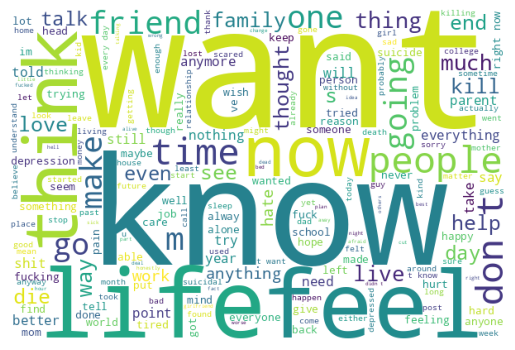

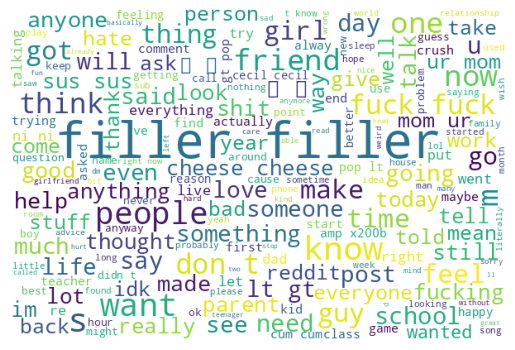

In [90]:
from wordcloud import WordCloud

def visualize(label, text_column):
    text = ''
    for msg in df[df['class'] == label][text_column]:
        msg = msg.lower()
        text += msg + ' '
    wordcloud = WordCloud(width=600, height=400, background_color="white").generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

visualize('suicide', 'text')
visualize('non-suicide', 'text')

Після передобробки даних виведемо візуалізацію найбільш поширених слів.

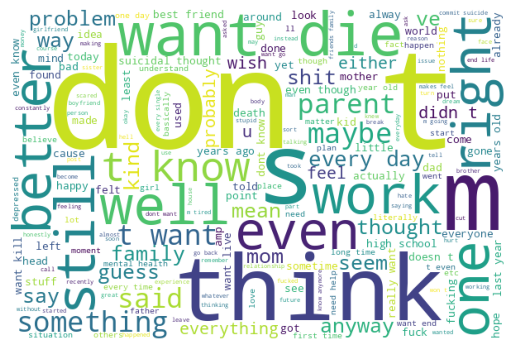

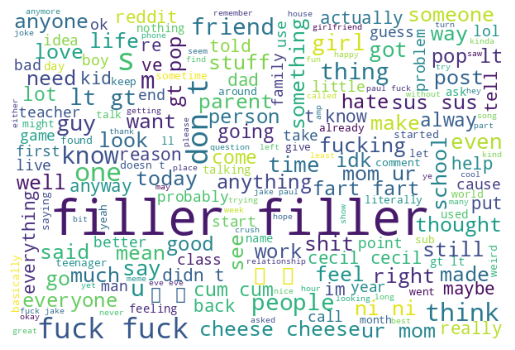

In [91]:
visualize('suicide', 'clean_text')
visualize('non-suicide', 'clean_text')

In [92]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer, WordNetLemmatizer


# lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def additional_change(text):
    # застосовуємо лематизацію
    words = [w for w in text.split() if w not in stop_words]
    # words = [lemmatizer.lemmatize(w) for w in words]
    words = [stemmer.stem(w) for w in words]
    return " ".join(words).strip()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [93]:
sample = "I was listing several listed items in my lists."
print(additional_change(sample))

i list sever list item lists.


In [94]:
df['add_clean_text'] = df['clean_text'].apply(additional_change)

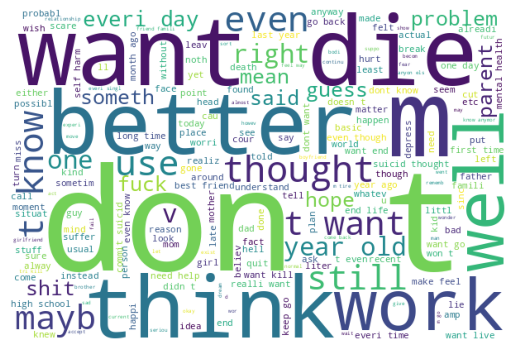

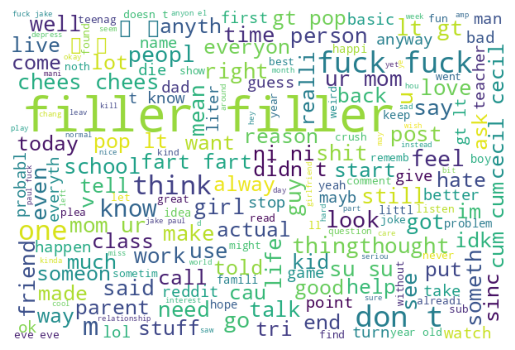

In [95]:
visualize('suicide', 'add_clean_text')
visualize('non-suicide', 'add_clean_text')

Векторизуємо тексти

TfidfVectorizer перетворює тексти → числові вектори.

fit_transform() використовується для тренувального набору.

Отриману матрицю X можна подати у будь-який класифікатор (LogisticRegression, SVM, RandomForest, NaiveBayes, тощо).

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=1000,       # обмеження розміру словника (можна збільшити)
    ngram_range=(1, 2)      # уніграми + біграми
)

# 4️⃣ — Навчимо векторизатор на всіх текстах
X = tfidf.fit_transform(df['add_clean_text'])
y = df['class']

# (кількість текстів (рядків у датасеті), кількість унікальних термів (словосполучень) після обмеження max_features)
print("Розмірність матриці TF-IDF:", X.shape)

Розмірність матриці TF-IDF: (232074, 1000)


MultinomialNB не враховує взаємодії слів і не підтримує регуляризацію, як LogisticRegression, також текстові ознаки досить не чітко відокремлюють класи, тому прийнято рішення використовувати LogisticRegression.

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# Розділяємо дані
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Створюємо і навчаємо модель
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Передбачення
y_pred = model.predict(X_test)

# Оцінка
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

 non-suicide     0.9142    0.9321    0.9231     23208
     suicide     0.9307    0.9126    0.9216     23207

    accuracy                         0.9223     46415
   macro avg     0.9225    0.9223    0.9223     46415
weighted avg     0.9225    0.9223    0.9223     46415



In [105]:
# --- Accuracy
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)

Accuracy: 0.9223311429494775


In [99]:
# --- Confusion matrix
confusion_matrix(y_test, y_pred)

array([[21632,  1576],
       [ 2029, 21178]])

In [100]:
feat_names = tfidf.get_feature_names_out()
coefs = model.coef_[0]  # тільки один рядок

# Позитивні коефіцієнти → другий клас (класифікуємо як "1")
top_idx_pos = coefs.argsort()[-20:][::-1]
top_feats_pos = [(feat_names[i], coefs[i]) for i in top_idx_pos if coefs[i] > 0]

# Негативні коефіцієнти → перший клас (класифікуємо як "0")
top_idx_neg = coefs.argsort()[:20]
top_feats_neg = [(feat_names[i], coefs[i]) for i in top_idx_neg if coefs[i] < 0]

print(f"\nTop features for class '{model.classes_[1]}' (positive):")
for word, coef in top_feats_pos:
    print(f"{word}: {coef:.4f}")

print(f"\nTop features for class '{model.classes_[0]}' (negative):")
for word, coef in top_feats_neg:
    print(f"{word}: {coef:.4f}")



Top features for class 'suicide' (positive):
suicid: 15.7173
kill: 9.2144
pill: 6.9166
overdos: 6.7614
life: 5.7131
anymor: 5.6192
want die: 5.5440
aliv: 5.5438
end: 5.4517
jump: 5.0451
method: 4.8853
die: 4.8063
hang: 4.7292
attempt: 4.6602
tonight: 4.6113
get better: 4.6064
hopeless: 4.5549
live: 4.5365
goodby: 4.4399
hospit: 4.4130

Top features for class 'non-suicide' (negative):
teenag: -6.2679
dm: -5.3989
rant: -4.7707
crush: -4.2729
discord: -4.1535
meme: -4.0475
teen: -3.8943
covid: -3.6511
teacher: -3.5153
cute: -3.4870
boy: -3.3756
cool: -3.3466
like: -3.3093
filler: -3.2688
tho: -3.1352
rn: -3.1105
ye: -3.0509
bore: -2.9782
also: -2.9718
wear: -2.9430


Позитивні коефіцієнти означають, що слово підвищує ймовірність цього класу.

Негативні коефіцієнти означають, що слово підвищує ймовірність іншого класу (non-suicide).

Додаткого перевіримо інші дві колонки

In [101]:
X1 = tfidf.fit_transform(df['text'])
X2 = tfidf.fit_transform(df['clean_text'])

In [102]:
# for 'text'
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

model.fit(X_train, y_train)

# Передбачення
y_pred = model.predict(X_test)

# Оцінка
print(classification_report(y_test, y_pred, digits=4))

# --- Accuracy
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

 non-suicide     0.9059    0.9300    0.9178     23208
     suicide     0.9281    0.9034    0.9156     23207

    accuracy                         0.9167     46415
   macro avg     0.9170    0.9167    0.9167     46415
weighted avg     0.9170    0.9167    0.9167     46415

Accuracy: 0.9167079607885382


In [103]:
# for 'clean_text'
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42, stratify=y)

model.fit(X_train, y_train)

# Передбачення
y_pred = model.predict(X_test)

# Оцінка
print(classification_report(y_test, y_pred, digits=4))

# --- Accuracy
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

 non-suicide     0.9108    0.9310    0.9208     23208
     suicide     0.9294    0.9088    0.9190     23207

    accuracy                         0.9199     46415
   macro avg     0.9201    0.9199    0.9199     46415
weighted avg     0.9201    0.9199    0.9199     46415

Accuracy: 0.9199181299148982


## Висновок 3

Була проведена класифікація текстових даних.

* Перед обробкою тексту (даних) Accuracy: 0.9167079607885382
* Після обробки, але перед алгоритмічним обрізанням закінчень (Stemming) Accuracy: 0.9199181299148982
* Після Stemming Accuracy: 0.9223311429494775

Отже, найкраще себе показала модель класифікації (була застосована LogisticRegression) з уже обробленими даними (з Stemming).